In [29]:
from activity_tracker import utils
import sqlite3
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

data_dir = pathlib.Path("../data")
db_path = data_dir / "sqlite" / "analysis.db"
mapper_path = data_dir / "data_mapper.yml"
conn = sqlite3.connect(db_path)
mapping_dict = utils.load_data_mapper(mapper_path)

In [31]:
df_subject = pd.read_sql_query("SELECT * FROM subject", conn)
df_visit = pd.read_sql_query("SELECT * FROM visit", conn)
df_measurement = pd.read_sql_query("SELECT * FROM daily_measurement", conn)

# Convert date columns to datetime
df_measurement['date'] = pd.to_datetime(df_measurement['date'])
df_visit['date'] = pd.to_datetime(df_visit['date'])

# Pad subject_id for easier sorting
for df in [df_subject, df_visit, df_measurement]:
    if "subject_id" in df.columns:
        df["subject_id"] = df["subject_id"].str.replace(
            r"MDE(\d+)", 
            lambda m: f"MDE{int(m.group(1)):03d}", 
            regex=True
        )

# Filter measurements to only include days with measurements
start_col = df_measurement.columns.get_loc("percentage_wear_time") + 1
right_cols = df_measurement.columns[start_col:]
df_measurement = df_measurement[~df_measurement[right_cols].isna().all(axis=1)].reset_index(drop=True)
df_measurement.sort_values(by=["subject_id", "date"], inplace=True)
df_measurement

,subject_id,date,total_minutes_wear_time,percentage_wear_time,total_steps,total_distance,tracker_distance,logged_activities_distance,very_active_distance,moderately_active_distance,light_active_distance,sedentary_active_distance,very_active_minutes,fairly_active_minutes,lightly_active_minutes,sedentary_minutes,calories,floors,calories_bmr,marginal_calories,resting_heart_rate,average_sp_o2,min_sp_o2,max_sp_o2
0,MDE001,2021-07-19,85,5.902778,147.0,0.1100,0.1100,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,1440.0,1489.0,None,1489.0,0.0,NaN,NaN,NaN,NaN
1,MDE001,2021-07-20,630,43.750000,12.0,0.0100,0.0100,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,1440.0,1473.0,None,1457.0,0.0,NaN,NaN,NaN,NaN
2,MDE001,2021-07-21,0,0.000000,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,1440.0,1425.0,None,1425.0,0.0,NaN,NaN,NaN,NaN
3,MDE001,2021-07-22,0,0.000000,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,1440.0,1425.0,None,1425.0,0.0,NaN,NaN,NaN,NaN
4,MDE001,2021-07-23,0,0.000000,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,1440.0,1425.0,None,1425.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1643,MDE101,2025-05-08,109,7.569444,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,4.0,1436.0,1160.0,None,1152.0,7.0,NaN,NaN,NaN,NaN
1644,MDE101,2025-05-09,717,49.791667,3920.0,2.6631,2.6631,0.0,0.0,0.2084,2.4547,0.0,0.0,0.0,204.0,1236.0,1487.0,None,1152.0,268.0,56.0,NaN,NaN,NaN
1645,MDE101,2025-05-10,165,11.458333,1160.0,0.7877,0.7877,0.0,0.0,0.0470,0.7407,0.0,0.0,0.0,64.0,1376.0,1259.0,None,1152.0,86.0,NaN,NaN,NaN,NaN
1646,MDE101,2025-05-11,0,0.000000,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,1440.0,1152.0,None,1152.0,0.0,NaN,NaN,NaN,NaN


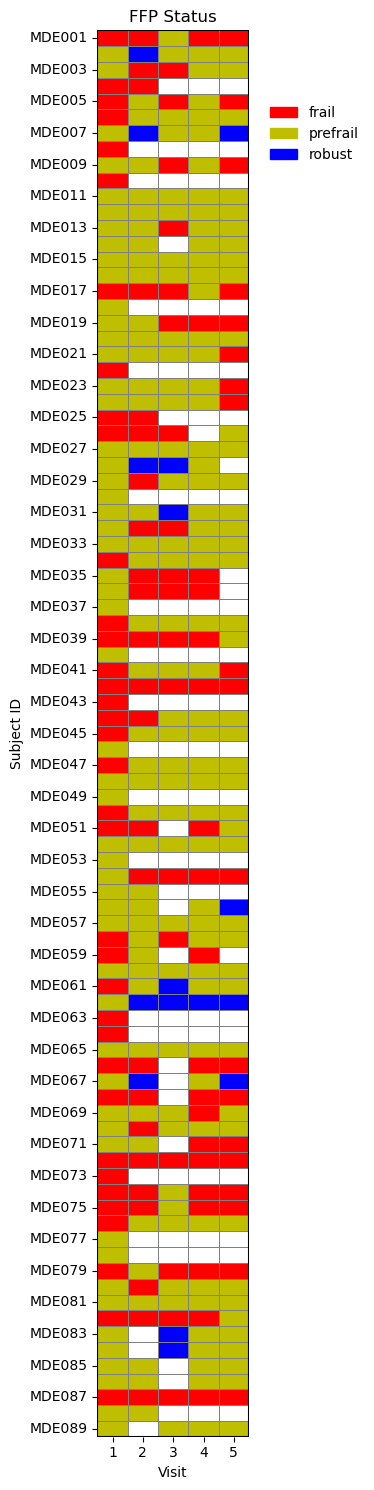

In [32]:
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
import matplotlib.patches as patches

from activity_tracker import utils

# Load mapping and set up colors/labels
colors = ['r', 'y', 'b']  # frail, prefrail, robust
cmap = ListedColormap(colors)
cmap.set_bad('white')  
bounds = [-0.5, 0.5, 1.5, 2.5]
norm = BoundaryNorm(bounds, cmap.N)

df_heat = df_visit.copy()
df_heat = df_heat.dropna(subset=["visit_id"])
df_heat['ffp_status'] = pd.to_numeric(df_heat['ffp_status'], errors='coerce')

heat_matrix = df_heat.pivot(index='subject_id', columns='visit_id', values='ffp_status')

# Ensure columns are sorted by visit number
heat_matrix = heat_matrix.reindex(sorted(heat_matrix.columns), axis=1)

# Plot
plt.figure(figsize=(4, 15))
ax = sns.heatmap(
    heat_matrix,
    cmap=cmap,
    norm=norm,
    linewidths=0.5,
    linecolor='gray',
    cbar=False,
    square=False,
    mask=heat_matrix.isna()
)

# Add a rectangle boundary around the heatmap
ax.add_patch(
    patches.Rectangle(
        (0, 0),
        heat_matrix.shape[1],
        heat_matrix.shape[0],
        fill=False,
        edgecolor='black',
        lw=1.5
    )
)

# Custom legend with dots
legend_labels = [mpatches.Patch(color=colors[i], label=mapping_dict['ffp_status'][i]) for i in range(3)]
plt.legend(
    handles=legend_labels,
    bbox_to_anchor=(1.1, 0.95),
    loc='upper left',
    borderaxespad=0.,
    frameon=False
)

plt.title('FFP Status')
plt.xlabel('Visit')
plt.ylabel('Subject ID')
plt.tight_layout()
plt.show()

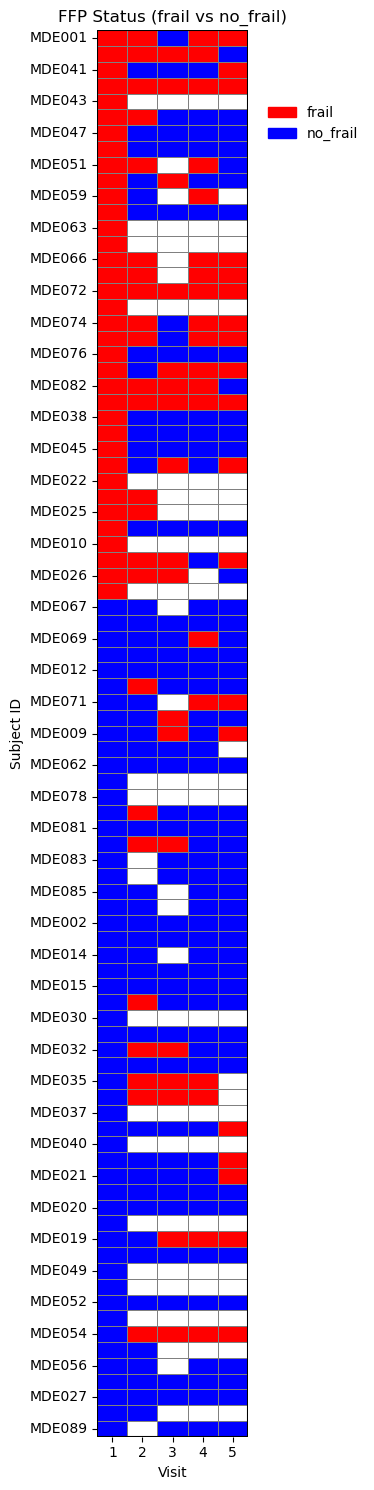

In [50]:
# Combine prefrail and robust into no_frail
heat_matrix_no_frail = heat_matrix.replace({1.0: 1, 2.0: 1})
heat_matrix_no_frail = heat_matrix_no_frail.sort_values(by=1)
# For plotting
colors = ['r', 'b']  # frail, no_frail
labels = ['frail', 'no_frail']
cmap = ListedColormap(colors)
cmap.set_bad('white')
bounds = [-0.5, 0.5, 1.5]
norm = BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(4, 15))
ax = sns.heatmap(
    heat_matrix_no_frail,
    cmap=cmap,
    norm=norm,
    linewidths=0.5,
    linecolor='gray',
    cbar=False,
    square=False,
    mask=heat_matrix_no_frail.isna()
)
# Add a rectangle boundary around the heatmap
ax.add_patch(
    patches.Rectangle(
        (0, 0),
        heat_matrix.shape[1],
        heat_matrix.shape[0],
        fill=False,
        edgecolor='black',
        lw=1.5
    )
)

# Custom legend
legend_labels = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(2)]
plt.legend(
    handles=legend_labels,
    bbox_to_anchor=(1.1, 0.95),
    loc='upper left',
    borderaxespad=0.,
    frameon=False
)

plt.title('FFP Status (frail vs no_frail)')
plt.xlabel('Visit')
plt.ylabel('Subject ID')
plt.tight_layout()
plt.show()

### Binary encoding of ffp_status to be frail vs. no_frail (prefrail and robust)

In [36]:
df_visit["ffp_status"] = df_visit["ffp_status"].astype(float).map(mapping_dict["ffp_status"])
# Combine 'prefrail' and 'robust' into 'no_frail'
df_visit['ffp_status_binary'] = df_visit['ffp_status'].replace({'prefrail': 'no_frail', 'robust': 'no_frail'})

In [53]:
df_measurement.query("subject_id == 'MDE001'").to_csv("measurement_MDE001.csv")

In [68]:
# Sankey plot of frailty status transitions across visits
import pandas as pd
import plotly.graph_objects as go

# Prepare your data
df_wide = df_visit.pivot(index='subject_id', columns='visit_id', values='ffp_status_binary')
df_wide = df_wide.sort_index(axis=1) 

labels = ['frail', 'no_frail']
short_labels = {'frail': 'F', 'no_frail': 'N'}

# Node labels: just short label (count)
node_labels = []
for v in range(1, df_wide.shape[1]+1):
    for label in labels:
        count = (df_wide[v] == label).sum()
        node_labels.append(f"{short_labels[label]} ({count})")

sources = []
targets = []
values = []
custom_labels = []

for v in range(1, df_wide.shape[1]): 
    from_states = df_wide[v]
    to_states = df_wide[v+1]
    ct = pd.crosstab(from_states, to_states)
    for i, from_label in enumerate(labels):
        for j, to_label in enumerate(labels):
            count = ct.get(to_label, {}).get(from_label, 0)
            if count > 0:
                sources.append(i + (v-1)*len(labels))
                targets.append(j + v*len(labels))
                values.append(count)
                custom_labels.append(f"{short_labels[from_label]}→{short_labels[to_label]}: {count}")

# Two colors: red for frail, blue for no_frail
color_map = {'frail': 'crimson', 'no_frail': 'royalblue'}
node_colors = []
for v in range(df_wide.shape[1]):
    node_colors.extend([color_map[label] for label in labels])

fig = go.Figure(data=[go.Sankey(
    node=dict(label=node_labels, color=node_colors, pad=40, thickness=40),
    link=dict(source=sources, target=targets, value=values, label=custom_labels)
)])

n_visits = df_wide.shape[1]
for v in range(n_visits):
    x = v / (n_visits - 1) if n_visits > 1 else 0.5
    fig.add_annotation(
        x=x,
        y=-0.15,
        text=f"Visit {v+1}",
        showarrow=False,
        font=dict(size=15),
        xref="paper",
        yref="paper"
    )

fig.show()

In [75]:
# Assuming df_visit is already loaded and has 'subject_id', 'visit_id', 'ffp_status_binary'
df = df_visit[['subject_id', 'visit_id', 'ffp_status_binary']].dropna(subset=['ffp_status_binary'])
df = df.sort_values(['subject_id', 'visit_id'])

transitions = {
    ('frail', 'frail'): 0,
    ('frail', 'no_frail'): 0,
    ('no_frail', 'frail'): 0,
    ('no_frail', 'no_frail'): 0
}

for subject, group in df.groupby('subject_id'):
    states = group['ffp_status_binary'].tolist()
    for i in range(len(states) - 1):
        if pd.notna(states[i]) and pd.notna(states[i+1]):
            transitions[(states[i], states[i+1])] += 1

transition_matrix = pd.DataFrame(
    [[transitions[('frail', 'frail')], transitions[('frail', 'no_frail')]],
     [transitions[('no_frail', 'frail')], transitions[('no_frail', 'no_frail')]]],
    index=['frail', 'no_frail'],
    columns=['frail', 'no_frail']
)
print(transition_matrix)

          frail  no_frail
frail        53        32
no_frail     27       150


In [76]:
import numpy as np
prob_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)
print(prob_matrix)

eigvals, eigvecs = np.linalg.eig(prob_matrix.T)
stationary = np.real(eigvecs[:, np.isclose(eigvals, 1)])
stationary = stationary / stationary.sum()
print("Stationary distribution:", stationary.flatten())

             frail  no_frail
frail     0.623529  0.376471
no_frail  0.152542  0.847458
Stationary distribution: [0.28835281 0.71164719]


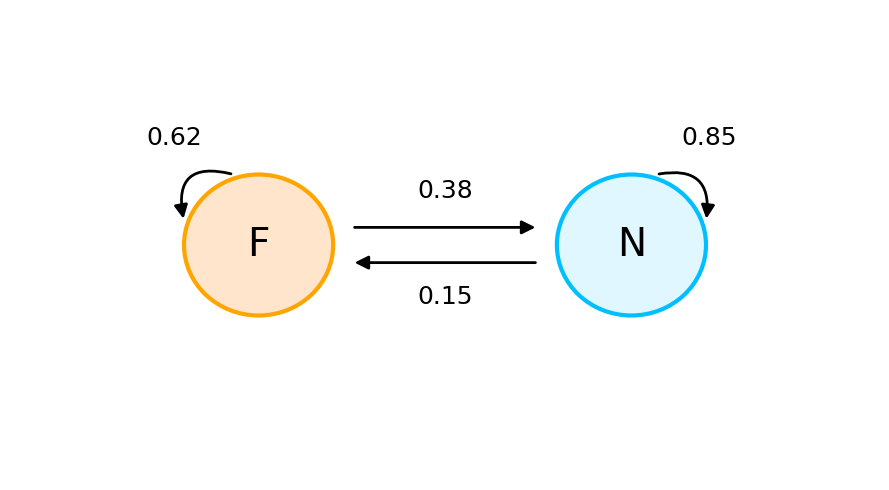

In [110]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, FancyArrowPatch

# Transition probabilities
probs = {
    ('F', 'F'): 0.62,
    ('F', 'N'): 0.38,
    ('N', 'F'): 0.15,
    ('N', 'N'): 0.85
}

# Node positions
node_pos = {'F': (0, 0), 'N': (3, 0)}

fig, ax = plt.subplots(figsize=(9, 5))
ax.set_xlim(-2, 5)
ax.set_ylim(-2, 2)
ax.axis('off')

# Draw ellipses for nodes
ellipse_F = Ellipse(xy=node_pos['F'], width=1.2, height=1.2,
                    edgecolor='orange', facecolor='#ffe5cc', lw=3)
ellipse_N = Ellipse(xy=node_pos['N'], width=1.2, height=1.2,
                    edgecolor='deepskyblue', facecolor='#e0f7ff', lw=3)
ax.add_patch(ellipse_F)
ax.add_patch(ellipse_N)

# Add node labels
ax.text(*node_pos['F'], 'F', fontsize=28, ha='center', va='center')
ax.text(*node_pos['N'], 'N', fontsize=28, ha='center', va='center')

# Arrow style
arrowprops = dict(arrowstyle='-|>', color='black', lw=2, mutation_scale=20)

# Self-loop F
arrow = FancyArrowPatch((node_pos['F'][0] - 0.2, node_pos['F'][1] + 0.6),
                        (node_pos['F'][0] - 0.6, node_pos['F'][1] + 0.2),
                        connectionstyle="arc3,rad=0.8", **arrowprops)
ax.add_patch(arrow)
ax.text(node_pos['F'][0] - 0.9, node_pos['F'][1] + 0.85,
        f"{probs[('F','F')]:.2f}", fontsize=18)

# Self-loop N
arrow = FancyArrowPatch((node_pos['N'][0] + 0.2, node_pos['N'][1] + 0.6),
                        (node_pos['N'][0] + 0.6, node_pos['N'][1] + 0.2),
                        connectionstyle="arc3,rad=-0.7", **arrowprops)
ax.add_patch(arrow)
ax.text(node_pos['N'][0] + 0.4, node_pos['N'][1] + 0.85,
        f"{probs[('N','N')]:.2f}", fontsize=18)

# F → N
arrow = FancyArrowPatch((node_pos['F'][0] + 0.75, node_pos['F'][1] + 0.15),
                        (node_pos['N'][0] - 0.75, node_pos['N'][1] + 0.15),
                        connectionstyle="arc3,rad=0.0", **arrowprops)
ax.add_patch(arrow)
ax.text(1.5, 0.4, f"{probs[('F','N')]:.2f}", fontsize=18, ha='center')

# N → F
arrow = FancyArrowPatch((node_pos['N'][0] - 0.75, node_pos['N'][1] - 0.15),
                        (node_pos['F'][0] + 0.75, node_pos['F'][1] - 0.15),
                        connectionstyle="arc3,rad=0.0", **arrowprops)
ax.add_patch(arrow)
ax.text(1.5, -0.5, f"{probs[('N','F')]:.2f}", fontsize=18, ha='center')

plt.tight_layout()
plt.show()